Try:

```
[ ] Way more bits.
[ ] Soft version.
[ ] No narrow in gumble sampling.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
CUDA = torch.cuda.is_available()

In [6]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [7]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [8]:
# hyperparameters
N = 5
k = 2
tau = 1.
SEED = 1337

In [9]:
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

In [10]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2*N),
            nn.ReLU(),
        )
        
    def forward(self, x):
        bits = self.net(x)
        bits = bits.view(-1, N, 2)
        return bits

In [12]:
def prob(outputs, N=N, k=k):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

In [13]:
class Decoder(nn.Module):
    def __init__(self, n_bits):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_bits, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.net(x)

# class RecDecoderHead(nn.Module):
#     def __init__(self):
#         super(RecDecoderHead, self).__init__()
#         self.fc = nn.Linear(1, 128)
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         return self.relu(self.fc(x))
    
# class RecDecoderBody(nn.Module):
#     def __init__(self):
#         super(RecDecoderBody, self).__init__()
#         self.fc = nn.Linear(129, 128) # prev state + hidden
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         return self.relu(self.fc(x))
    
# class RecDecoderTail(nn.Module):  
#     def __init__(self):
#         super(RecDecoderTail, self).__init__()
#         self.fc1 = nn.Linear(128, 256)
#         self.fc2 = nn.Linear(256, 512)      
#         self.fc3 = nn.Linear(512, 784)
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         h1 = self.relu(self.fc1(x))
#         h2 = self.relu(self.fc2(h1))
#         h3 = self.fc3(h2)
#         o = h3.view(-1,784)
#         return F.sigmoid(o)    

In [14]:
E = Encoder()
Ds = [Decoder(d) for d in range(1, N+1)]
# D_head = RecDecoderHead()
# D_body = [RecDecoderBody() for _ in range(N-1)]
# D_tail = RecDecoderTail()

In [15]:
if CUDA:
    E.cuda()
    [D.cuda() for D in Ds]
#     D_head.cuda()
#     [e.cuda() for e in D_body]
#     D_tail.cuda()

In [16]:
from itertools import product
    
log_two_pow_ns = []

for n in range(N+1):
    log_two_pow_n = Variable(torch.Tensor([2**n]).log(), requires_grad=False)
    if CUDA:
        log_two_pow_n = log_two_pow_n.cuda()
    log_two_pow_ns.append(log_two_pow_n)

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    
    batch_size = x.shape[0]
    
    def get_kl(q, path, n, batch_size):
        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([batch_size]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_ns[n] + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch
        return kl_term
    
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
        
        outputs = E(x)
        outputs = outputs.permute(1,0,2) # make it like the list we had before

        kl_term = 0
        
        for nn in range(1, N+1):
            q = prob(outputs[:nn], nn)
            kl_term += get_kl(q, path[:nn], nn, batch_size)

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [17]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data.view(-1,784)
    x = x[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-02 *
  2.6664
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [18]:
def loss_function(recons, x):
    _bsize = x.shape[0]
    BCES = [F.binary_cross_entropy(recon_x, x, size_average=False)/_bsize for recon_x in recons]
    BCE = sum(BCES)
    
    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x) # this sums together the KLD
    
    return BCE, KLD

In [19]:
params = [
    {'params':E.parameters()}
] + [{'params':d.parameters()} for d in Ds]
optimizer = optim.Adam(params, lr=1e-4)

In [20]:
best_loss_sofar = 9999

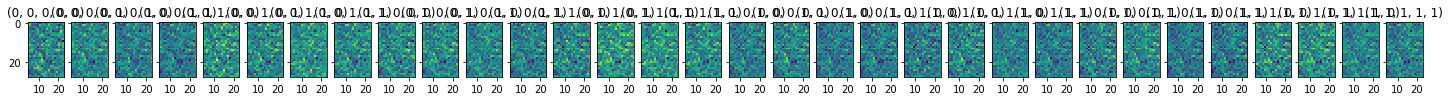

In [21]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        v = make_variable(path)
        w = Ds[-1](v)

        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()
    
debug()

In [22]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        
        outputs = E(x)
        recons = []
        samples = []
        for nn in range(N):
            s = sample(outputs[:,nn,:])
            samples.append(s)
            inp = torch.cat(samples, 1)
            recons.append(Ds[nn](inp))

        BCE, KLD = loss_function(recons, x)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()  
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                BCE.data[0] / len(data),
                KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
#         save_model()
        best_loss_sofar = avg_loss
        debug()
        
#     return q, bits # debugging

Train Epoch: 1 [0/60000 (0%)]	BCE loss: 27.238838	KLD loss: 0.000241
Train Epoch: 1 [20000/60000 (33%)]	BCE loss: 9.986753	KLD loss: 0.391954
Train Epoch: 1 [40000/60000 (67%)]	BCE loss: 10.335792	KLD loss: 0.394459
====> Epoch: 1 Average BCE loss: 11.7495, Average KLD loss: 0.3537, Total: 12.1032
Loss 12.103196308290334 is better than previous best 9999, saving model


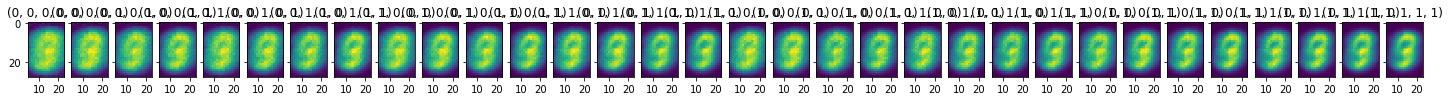

CPU times: user 1min 10s, sys: 1.39 s, total: 1min 11s
Wall time: 1min 10s


In [ ]:
%%time
train(0)

Train Epoch: 2 [0/60000 (0%)]	BCE loss: 10.437604	KLD loss: 0.394609
Train Epoch: 2 [20000/60000 (33%)]	BCE loss: 10.411066	KLD loss: 0.394338
Train Epoch: 2 [40000/60000 (67%)]	BCE loss: 10.084723	KLD loss: 0.394143
====> Epoch: 2 Average BCE loss: 10.3008, Average KLD loss: 0.3455, Total: 10.6464
Loss 10.646360674071312 is better than previous best 12.103196308290334, saving model


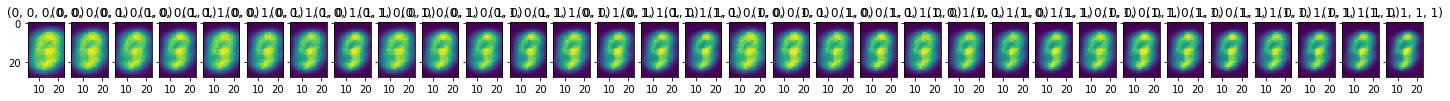

Train Epoch: 3 [0/60000 (0%)]	BCE loss: 10.523259	KLD loss: 0.079964
Train Epoch: 3 [20000/60000 (33%)]	BCE loss: 9.755332	KLD loss: 0.107443
Train Epoch: 3 [40000/60000 (67%)]	BCE loss: 9.975382	KLD loss: 0.130147
====> Epoch: 3 Average BCE loss: 9.8690, Average KLD loss: 0.1264, Total: 9.9954
Loss 9.995415263851484 is better than previous best 10.646360674071312, saving model


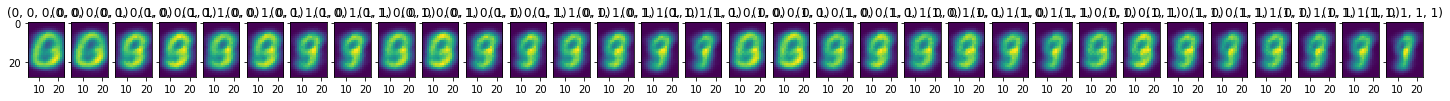

Train Epoch: 4 [0/60000 (0%)]	BCE loss: 10.042768	KLD loss: 0.129824
Train Epoch: 4 [20000/60000 (33%)]	BCE loss: 9.633456	KLD loss: 0.118155
Train Epoch: 4 [40000/60000 (67%)]	BCE loss: 9.780679	KLD loss: 0.159125
====> Epoch: 4 Average BCE loss: 9.7590, Average KLD loss: 0.1418, Total: 9.9008
Loss 9.900795241212844 is better than previous best 9.995415263851484, saving model


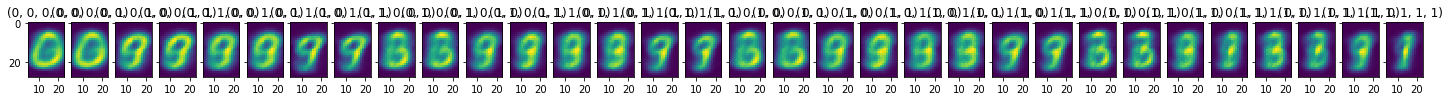

Train Epoch: 5 [0/60000 (0%)]	BCE loss: 9.454944	KLD loss: 0.148999
Train Epoch: 5 [20000/60000 (33%)]	BCE loss: 9.261192	KLD loss: 0.163980
Train Epoch: 5 [40000/60000 (67%)]	BCE loss: 9.351298	KLD loss: 0.186396
====> Epoch: 5 Average BCE loss: 9.5496, Average KLD loss: 0.1715, Total: 9.7211
Loss 9.721111486975353 is better than previous best 9.900795241212844, saving model


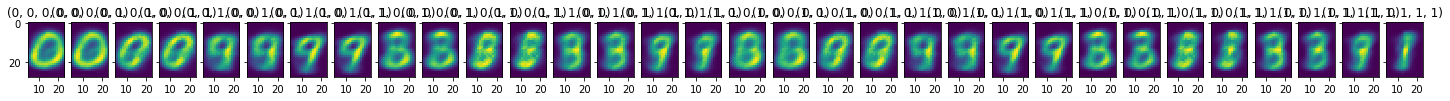

Train Epoch: 6 [0/60000 (0%)]	BCE loss: 9.597784	KLD loss: 0.181322
Train Epoch: 6 [20000/60000 (33%)]	BCE loss: 8.921478	KLD loss: 0.201641
Train Epoch: 6 [40000/60000 (67%)]	BCE loss: 8.640243	KLD loss: 0.241563
====> Epoch: 6 Average BCE loss: 9.3070, Average KLD loss: 0.2098, Total: 9.5167
Loss 9.516749554475147 is better than previous best 9.721111486975353, saving model


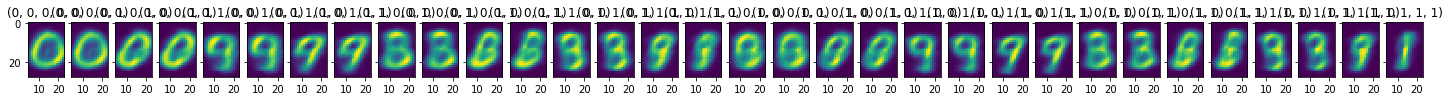

Train Epoch: 7 [0/60000 (0%)]	BCE loss: 9.279717	KLD loss: 0.219100
Train Epoch: 7 [20000/60000 (33%)]	BCE loss: 9.480259	KLD loss: 0.212797
Train Epoch: 7 [40000/60000 (67%)]	BCE loss: 8.932632	KLD loss: 0.242621
====> Epoch: 7 Average BCE loss: 9.2138, Average KLD loss: 0.2316, Total: 9.4453
Loss 9.44534276526769 is better than previous best 9.516749554475147, saving model


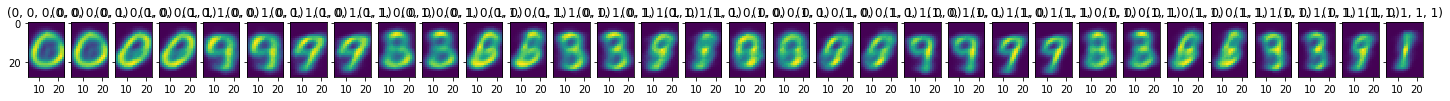

Train Epoch: 8 [0/60000 (0%)]	BCE loss: 9.276120	KLD loss: 0.222820
Train Epoch: 8 [20000/60000 (33%)]	BCE loss: 8.895056	KLD loss: 0.239344
Train Epoch: 8 [40000/60000 (67%)]	BCE loss: 8.841978	KLD loss: 0.249936
====> Epoch: 8 Average BCE loss: 9.1534, Average KLD loss: 0.2416, Total: 9.3950
Loss 9.395014630667369 is better than previous best 9.44534276526769, saving model


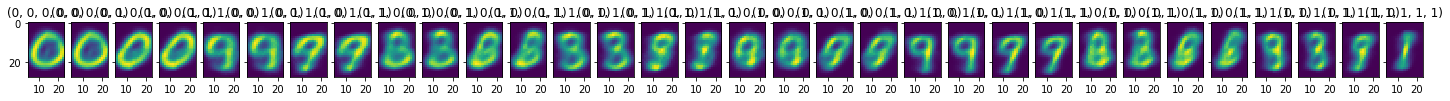

Train Epoch: 9 [0/60000 (0%)]	BCE loss: 9.008386	KLD loss: 0.246784
Train Epoch: 9 [20000/60000 (33%)]	BCE loss: 9.313474	KLD loss: 0.248896
Train Epoch: 9 [40000/60000 (67%)]	BCE loss: 8.906005	KLD loss: 0.256857
====> Epoch: 9 Average BCE loss: 9.1227, Average KLD loss: 0.2470, Total: 9.3698
Loss 9.369764206123353 is better than previous best 9.395014630667369, saving model


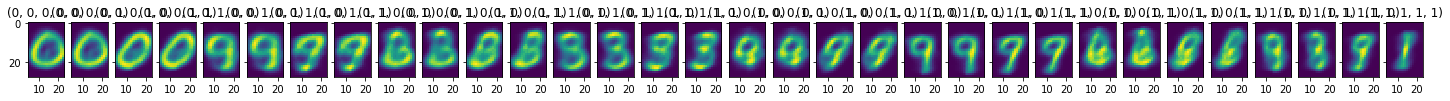

Train Epoch: 10 [0/60000 (0%)]	BCE loss: 9.331769	KLD loss: 0.248936
Train Epoch: 10 [20000/60000 (33%)]	BCE loss: 9.334606	KLD loss: 0.248524
Train Epoch: 10 [40000/60000 (67%)]	BCE loss: 9.907999	KLD loss: 0.244341
====> Epoch: 10 Average BCE loss: 9.0892, Average KLD loss: 0.2511, Total: 9.3403
Loss 9.340264263852436 is better than previous best 9.369764206123353, saving model


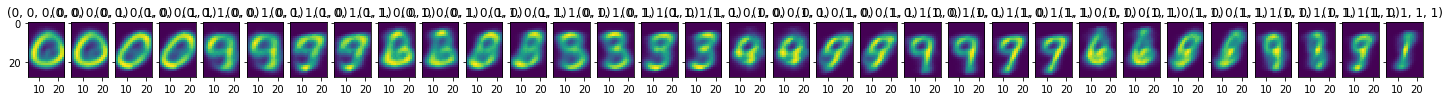

Train Epoch: 11 [0/60000 (0%)]	BCE loss: 8.703324	KLD loss: 0.269625
Train Epoch: 11 [20000/60000 (33%)]	BCE loss: 9.015773	KLD loss: 0.242830
Train Epoch: 11 [40000/60000 (67%)]	BCE loss: 8.995875	KLD loss: 0.258636
====> Epoch: 11 Average BCE loss: 9.0679, Average KLD loss: 0.2546, Total: 9.3225
Loss 9.322510871569316 is better than previous best 9.340264263852436, saving model


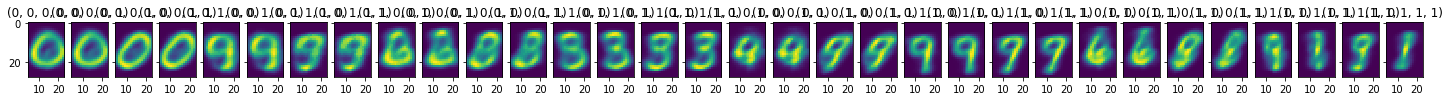

Train Epoch: 12 [0/60000 (0%)]	BCE loss: 9.509639	KLD loss: 0.258679
Train Epoch: 12 [20000/60000 (33%)]	BCE loss: 9.208082	KLD loss: 0.268177
Train Epoch: 12 [40000/60000 (67%)]	BCE loss: 8.704910	KLD loss: 0.264488
====> Epoch: 12 Average BCE loss: 9.0512, Average KLD loss: 0.2558, Total: 9.3070
Loss 9.307004081058503 is better than previous best 9.322510871569316, saving model


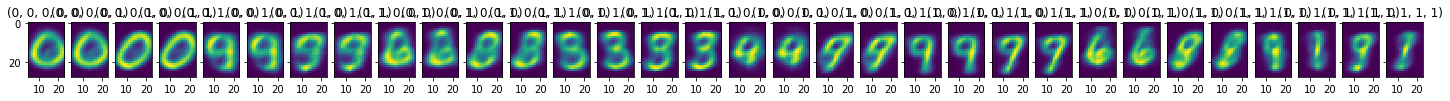

Train Epoch: 13 [0/60000 (0%)]	BCE loss: 9.217950	KLD loss: 0.251834
Train Epoch: 13 [20000/60000 (33%)]	BCE loss: 9.266369	KLD loss: 0.261967
Train Epoch: 13 [40000/60000 (67%)]	BCE loss: 9.003927	KLD loss: 0.259752
====> Epoch: 13 Average BCE loss: 9.0394, Average KLD loss: 0.2584, Total: 9.2978
Loss 9.297790844885508 is better than previous best 9.307004081058503, saving model


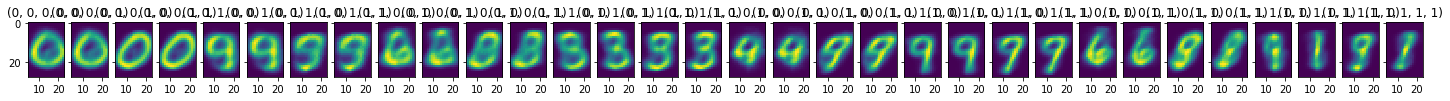

Train Epoch: 14 [0/60000 (0%)]	BCE loss: 8.851907	KLD loss: 0.267806
Train Epoch: 14 [20000/60000 (33%)]	BCE loss: 8.916926	KLD loss: 0.271757
Train Epoch: 14 [40000/60000 (67%)]	BCE loss: 8.853693	KLD loss: 0.266982
====> Epoch: 14 Average BCE loss: 9.0263, Average KLD loss: 0.2597, Total: 9.2859
Loss 9.285933878993987 is better than previous best 9.297790844885508, saving model


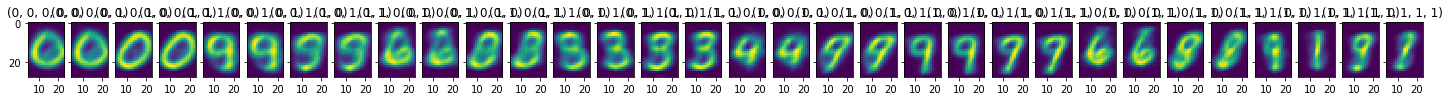

Train Epoch: 15 [0/60000 (0%)]	BCE loss: 9.248438	KLD loss: 0.241401
Train Epoch: 15 [20000/60000 (33%)]	BCE loss: 9.258141	KLD loss: 0.260912
Train Epoch: 15 [40000/60000 (67%)]	BCE loss: 8.905057	KLD loss: 0.254629
====> Epoch: 15 Average BCE loss: 9.0227, Average KLD loss: 0.2589, Total: 9.2816
Loss 9.28161946853002 is better than previous best 9.285933878993987, saving model


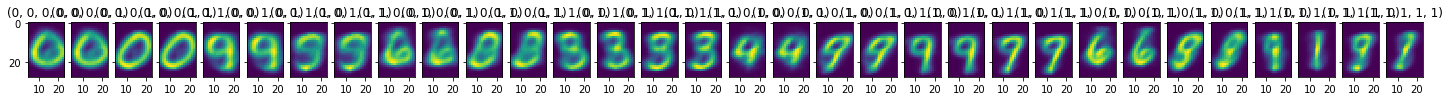

Train Epoch: 16 [0/60000 (0%)]	BCE loss: 9.169859	KLD loss: 0.256674
Train Epoch: 16 [20000/60000 (33%)]	BCE loss: 8.856833	KLD loss: 0.269839
Train Epoch: 16 [40000/60000 (67%)]	BCE loss: 9.220648	KLD loss: 0.240882
====> Epoch: 16 Average BCE loss: 9.0184, Average KLD loss: 0.2592, Total: 9.2777
Loss 9.277677209122976 is better than previous best 9.28161946853002, saving model


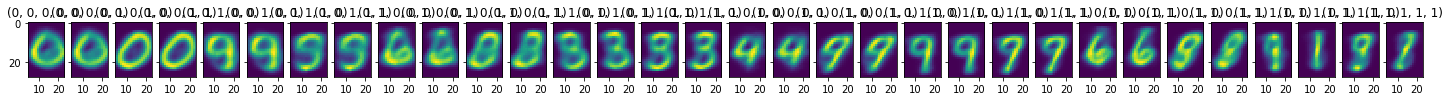

Train Epoch: 17 [0/60000 (0%)]	BCE loss: 9.637518	KLD loss: 0.257514
Train Epoch: 17 [20000/60000 (33%)]	BCE loss: 9.085022	KLD loss: 0.254460
Train Epoch: 17 [40000/60000 (67%)]	BCE loss: 9.152455	KLD loss: 0.260712
====> Epoch: 17 Average BCE loss: 9.0214, Average KLD loss: 0.2577, Total: 9.2791
Train Epoch: 18 [0/60000 (0%)]	BCE loss: 9.056467	KLD loss: 0.247341
Train Epoch: 18 [20000/60000 (33%)]	BCE loss: 9.000793	KLD loss: 0.251110
Train Epoch: 18 [40000/60000 (67%)]	BCE loss: 8.677688	KLD loss: 0.261944
====> Epoch: 18 Average BCE loss: 9.0189, Average KLD loss: 0.2591, Total: 9.2779
Train Epoch: 19 [0/60000 (0%)]	BCE loss: 8.727354	KLD loss: 0.259725
Train Epoch: 19 [20000/60000 (33%)]	BCE loss: 9.200022	KLD loss: 0.244985
Train Epoch: 19 [40000/60000 (67%)]	BCE loss: 9.036996	KLD loss: 0.250556
====> Epoch: 19 Average BCE loss: 9.0155, Average KLD loss: 0.2594, Total: 9.2750
Loss 9.27496210199992 is better than previous best 9.277677209122976, saving model


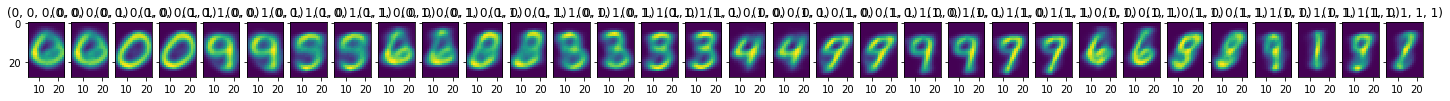

Train Epoch: 20 [0/60000 (0%)]	BCE loss: 9.182203	KLD loss: 0.243245
Train Epoch: 20 [20000/60000 (33%)]	BCE loss: 9.126089	KLD loss: 0.239236
Train Epoch: 20 [40000/60000 (67%)]	BCE loss: 8.761904	KLD loss: 0.264786
====> Epoch: 20 Average BCE loss: 9.0157, Average KLD loss: 0.2587, Total: 9.2743
Loss 9.274330042934418 is better than previous best 9.27496210199992, saving model


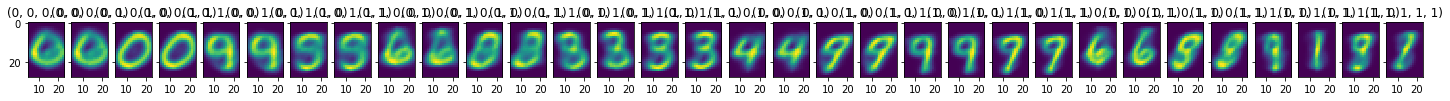

Train Epoch: 21 [0/60000 (0%)]	BCE loss: 9.331445	KLD loss: 0.259581
Train Epoch: 21 [20000/60000 (33%)]	BCE loss: 8.883699	KLD loss: 0.254546
Train Epoch: 21 [40000/60000 (67%)]	BCE loss: 9.178801	KLD loss: 0.263372
====> Epoch: 21 Average BCE loss: 9.0155, Average KLD loss: 0.2592, Total: 9.2746
Train Epoch: 22 [0/60000 (0%)]	BCE loss: 9.053447	KLD loss: 0.254398
Train Epoch: 22 [20000/60000 (33%)]	BCE loss: 8.883354	KLD loss: 0.251908
Train Epoch: 22 [40000/60000 (67%)]	BCE loss: 8.956757	KLD loss: 0.245739
====> Epoch: 22 Average BCE loss: 9.0141, Average KLD loss: 0.2578, Total: 9.2720
Loss 9.271972228272755 is better than previous best 9.274330042934418, saving model


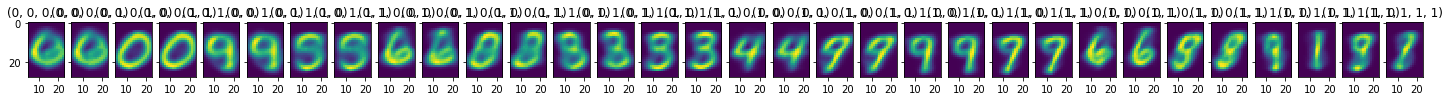

Train Epoch: 23 [0/60000 (0%)]	BCE loss: 8.680186	KLD loss: 0.266688
Train Epoch: 23 [20000/60000 (33%)]	BCE loss: 8.550898	KLD loss: 0.258224
Train Epoch: 23 [40000/60000 (67%)]	BCE loss: 8.961378	KLD loss: 0.256367
====> Epoch: 23 Average BCE loss: 9.0137, Average KLD loss: 0.2582, Total: 9.2719
Loss 9.271934928894042 is better than previous best 9.271972228272755, saving model


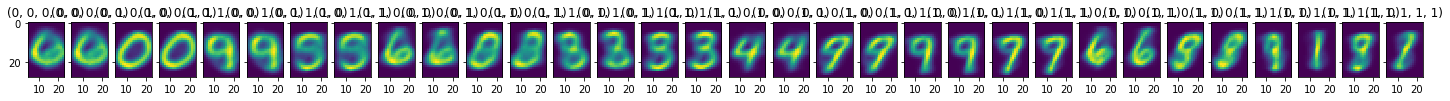

Train Epoch: 24 [0/60000 (0%)]	BCE loss: 9.061158	KLD loss: 0.247889
Train Epoch: 24 [20000/60000 (33%)]	BCE loss: 9.057406	KLD loss: 0.241038
Train Epoch: 24 [40000/60000 (67%)]	BCE loss: 9.263198	KLD loss: 0.247784
====> Epoch: 24 Average BCE loss: 9.0116, Average KLD loss: 0.2577, Total: 9.2693
Loss 9.269338423919677 is better than previous best 9.271934928894042, saving model


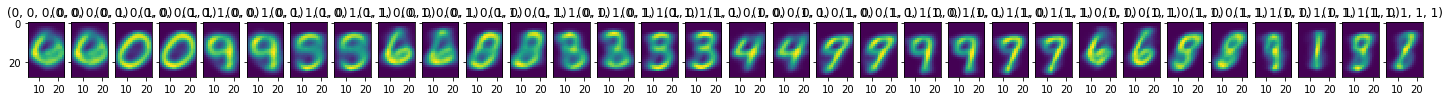

Train Epoch: 25 [0/60000 (0%)]	BCE loss: 8.786592	KLD loss: 0.259143
Train Epoch: 25 [20000/60000 (33%)]	BCE loss: 9.053677	KLD loss: 0.248086
Train Epoch: 25 [40000/60000 (67%)]	BCE loss: 9.138840	KLD loss: 0.240614
====> Epoch: 25 Average BCE loss: 9.0083, Average KLD loss: 0.2583, Total: 9.2666
Loss 9.266643826770782 is better than previous best 9.269338423919677, saving model


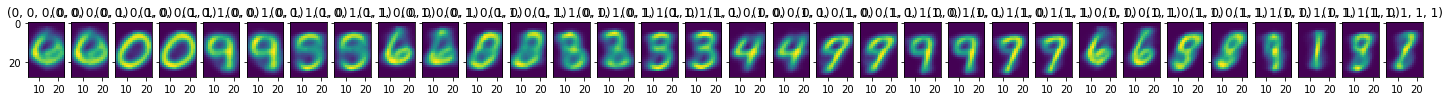

Train Epoch: 26 [0/60000 (0%)]	BCE loss: 9.318682	KLD loss: 0.252273
Train Epoch: 26 [20000/60000 (33%)]	BCE loss: 8.592231	KLD loss: 0.277659
Train Epoch: 26 [40000/60000 (67%)]	BCE loss: 8.697565	KLD loss: 0.273263
====> Epoch: 26 Average BCE loss: 9.0037, Average KLD loss: 0.2596, Total: 9.2633
Loss 9.263327057202657 is better than previous best 9.266643826770782, saving model


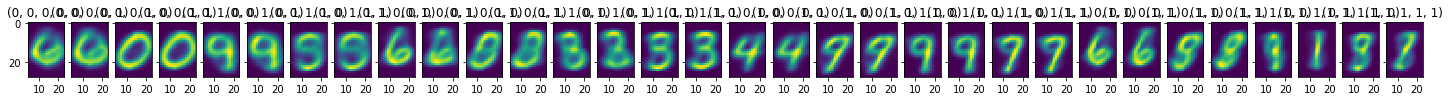

Train Epoch: 27 [0/60000 (0%)]	BCE loss: 9.346146	KLD loss: 0.246912
Train Epoch: 27 [20000/60000 (33%)]	BCE loss: 9.210375	KLD loss: 0.236167
Train Epoch: 27 [40000/60000 (67%)]	BCE loss: 8.949176	KLD loss: 0.253756
====> Epoch: 27 Average BCE loss: 9.0023, Average KLD loss: 0.2589, Total: 9.2612
Loss 9.261170506763458 is better than previous best 9.263327057202657, saving model


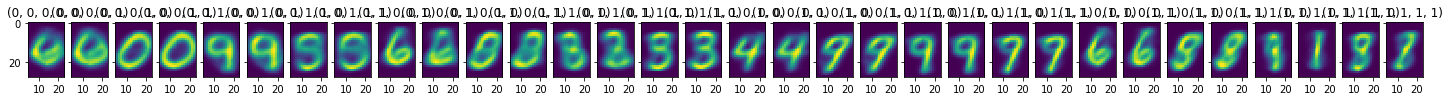

Train Epoch: 28 [0/60000 (0%)]	BCE loss: 9.017079	KLD loss: 0.251074
Train Epoch: 28 [20000/60000 (33%)]	BCE loss: 9.103875	KLD loss: 0.257779
Train Epoch: 28 [40000/60000 (67%)]	BCE loss: 9.059864	KLD loss: 0.247582
====> Epoch: 28 Average BCE loss: 9.0011, Average KLD loss: 0.2588, Total: 9.2600
Loss 9.259952693589529 is better than previous best 9.261170506763458, saving model


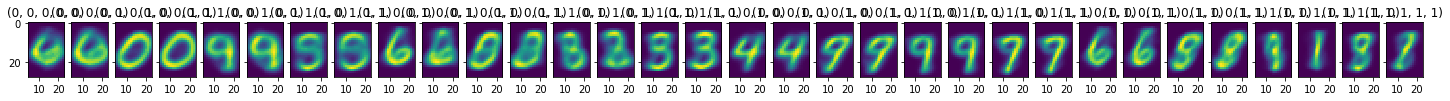

Train Epoch: 29 [0/60000 (0%)]	BCE loss: 8.839939	KLD loss: 0.249228
Train Epoch: 29 [20000/60000 (33%)]	BCE loss: 8.641984	KLD loss: 0.258972
Train Epoch: 29 [40000/60000 (67%)]	BCE loss: 9.485835	KLD loss: 0.238101
====> Epoch: 29 Average BCE loss: 9.0044, Average KLD loss: 0.2567, Total: 9.2611
Train Epoch: 30 [0/60000 (0%)]	BCE loss: 9.189586	KLD loss: 0.242717
Train Epoch: 30 [20000/60000 (33%)]	BCE loss: 9.107927	KLD loss: 0.254774
Train Epoch: 30 [40000/60000 (67%)]	BCE loss: 8.650677	KLD loss: 0.260540
====> Epoch: 30 Average BCE loss: 9.0016, Average KLD loss: 0.2576, Total: 9.2592
Loss 9.259204139264424 is better than previous best 9.259952693589529, saving model


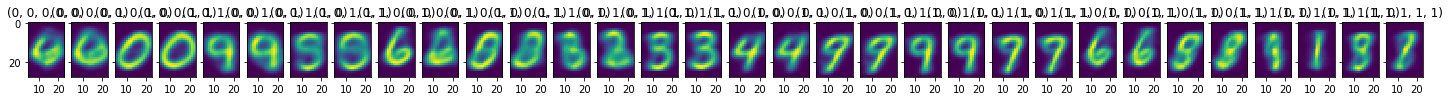

Train Epoch: 31 [0/60000 (0%)]	BCE loss: 8.859072	KLD loss: 0.260415
Train Epoch: 31 [20000/60000 (33%)]	BCE loss: 8.781560	KLD loss: 0.266235
Train Epoch: 31 [40000/60000 (67%)]	BCE loss: 9.230457	KLD loss: 0.271592
====> Epoch: 31 Average BCE loss: 8.9968, Average KLD loss: 0.2592, Total: 9.2560
Loss 9.255953165245055 is better than previous best 9.259204139264424, saving model


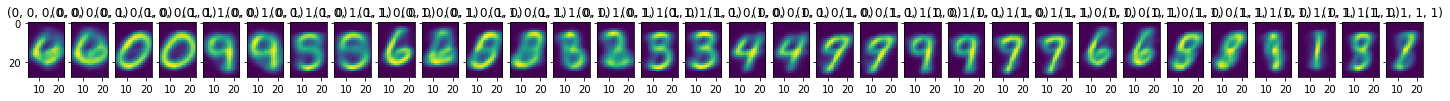

Train Epoch: 32 [0/60000 (0%)]	BCE loss: 9.099537	KLD loss: 0.259600
Train Epoch: 32 [20000/60000 (33%)]	BCE loss: 9.261041	KLD loss: 0.254461
Train Epoch: 32 [40000/60000 (67%)]	BCE loss: 8.993689	KLD loss: 0.254614
====> Epoch: 32 Average BCE loss: 9.0002, Average KLD loss: 0.2581, Total: 9.2584
Train Epoch: 33 [0/60000 (0%)]	BCE loss: 9.179440	KLD loss: 0.271591
Train Epoch: 33 [20000/60000 (33%)]	BCE loss: 9.293184	KLD loss: 0.244480
Train Epoch: 33 [40000/60000 (67%)]	BCE loss: 8.363815	KLD loss: 0.266751
====> Epoch: 33 Average BCE loss: 9.0036, Average KLD loss: 0.2578, Total: 9.2615
Train Epoch: 34 [0/60000 (0%)]	BCE loss: 9.033611	KLD loss: 0.266248
Train Epoch: 34 [20000/60000 (33%)]	BCE loss: 8.906392	KLD loss: 0.270120
Train Epoch: 34 [40000/60000 (67%)]	BCE loss: 8.645106	KLD loss: 0.265656
====> Epoch: 34 Average BCE loss: 8.9977, Average KLD loss: 0.2590, Total: 9.2568
Train Epoch: 35 [0/60000 (0%)]	BCE loss: 8.690526	KLD loss: 0.263707
Train Epoch: 35 [20000/60000 (33%)

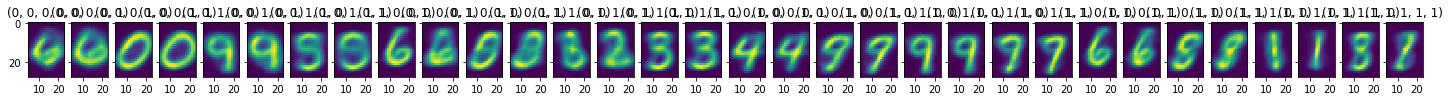

Train Epoch: 36 [0/60000 (0%)]	BCE loss: 8.966362	KLD loss: 0.264874
Train Epoch: 36 [20000/60000 (33%)]	BCE loss: 8.782117	KLD loss: 0.249632
Train Epoch: 36 [40000/60000 (67%)]	BCE loss: 9.084904	KLD loss: 0.269840
====> Epoch: 36 Average BCE loss: 8.9937, Average KLD loss: 0.2589, Total: 9.2527
Loss 9.252662045288085 is better than previous best 9.25324042224884, saving model


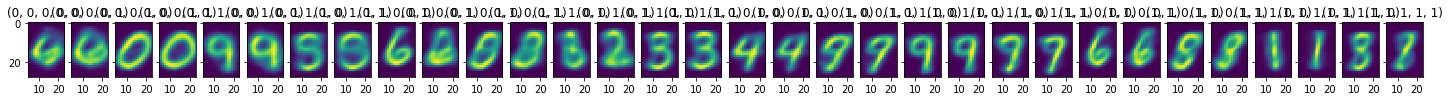

Train Epoch: 37 [0/60000 (0%)]	BCE loss: 8.928502	KLD loss: 0.244266
Train Epoch: 37 [20000/60000 (33%)]	BCE loss: 8.804595	KLD loss: 0.262798
Train Epoch: 37 [40000/60000 (67%)]	BCE loss: 8.790670	KLD loss: 0.258238
====> Epoch: 37 Average BCE loss: 8.9992, Average KLD loss: 0.2566, Total: 9.2559
Train Epoch: 38 [0/60000 (0%)]	BCE loss: 8.681766	KLD loss: 0.253135
Train Epoch: 38 [20000/60000 (33%)]	BCE loss: 9.176443	KLD loss: 0.248834
Train Epoch: 38 [40000/60000 (67%)]	BCE loss: 9.315236	KLD loss: 0.254220
====> Epoch: 38 Average BCE loss: 8.9957, Average KLD loss: 0.2573, Total: 9.2530
Train Epoch: 39 [0/60000 (0%)]	BCE loss: 9.019236	KLD loss: 0.246867
Train Epoch: 39 [20000/60000 (33%)]	BCE loss: 8.765751	KLD loss: 0.271649


In [ ]:
for epoch in range(1,100):
    train(epoch)

In [ ]:
debug()